# Figure 3, 4 and S6: Anomaly propagation

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
import sys
sys.path.append(
    "/g/data/e14/cs6673/Ross_salinity/Python_scripts_published/") 
from Info_definitions import (
    path_database, path_output, path_plots, exptdict, yearly_mean,
    shelf_mask_isobath)
from gsw import SA_from_SP, p_from_z

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cmocean
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import calendar
import string

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36801,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:33815,Total threads: 4
Dashboard: /proxy/36671/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:42689,


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23173800318784 and this is thread id 23172197136128.
Exception closing connection <sqlite3.Connection object at 0x1513523a6a40>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/sit

## Load data

In [4]:
%%time
ekeys = ['ctrl', 'wind_50_down_zonal', 'mw_50_down']
start_time = '2150-01-01'
end_time = '2159-12-31'

ht = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'ht',
    session=cc.database.create_session(), n=1).sel(
    yt_ocean=slice(-90, -60))
land_mask = (ht*0).fillna(1)

yt_ocean_ext = cc.querying.getvar(
    exptdict['ctrl']['expt'], 'yt_ocean',
    session=cc.database.create_session(), frequency='static',
    n=1).sel(yt_ocean=slice(-90, -58.98))

for ekey in ekeys:
    print(ekey)
    e = exptdict[ekey]

        
    if ekey == 'ctrl':
        session = cc.database.create_session()
        expt_daily = 'access-om2-01_ryf_ctrl_rerun_salt_budget'
        session_daily = cc.database.create_session(
            path_database + expt_daily + '.db')
        path_output_daily = (
            '/g/data/e14/cs6673/outputs/access-om2-01/Ross_salinity/' +
            expt_daily + '/')
    else:
        db = (path_database + e['expt'] + '.db')
        session = cc.database.create_session(db)
        session_daily = session
        path_output_daily = (
            '/g/data/e14/cs6673/outputs/access-om2-01/Ross_salinity/' +
            e['expt'] + '/')

    # salt = cc.querying.getvar(
    #     e['expt'], 'salt', session, frequency='1 monthly',
    #     start_time=start_time, end_time=end_time,
    #     chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
    #         yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85))
    # # convert units to absolute salinity
    # pressure = p_from_z(-salt.st_ocean, salt.yt_ocean)
    # salt = SA_from_SP(salt, pressure, salt.xt_ocean, salt.yt_ocean)#.compute()
    # e['salt'], shelf_mask = shelf_mask_isobath(salt, output_mask=True)
    # print(e['salt'].shape)

    salt = cc.querying.getvar(
        e['expt'], 'salt', session,  ncfile='rregionocean_daily_3d_salt.nc',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean_sub01': '200MB', 'xt_ocean_sub01': '200MB'})
    salt = salt.rename(
        {'xt_ocean_sub01': 'xt_ocean', 'yt_ocean_sub01': 'yt_ocean'})
    salt['yt_ocean'] = yt_ocean_ext
    e['salt_d'] = salt.sel(yt_ocean=slice(-79, -70), xt_ocean=slice(-200, -95))

    e['dzt'] = cc.querying.getvar(
        e['expt'], 'dzt', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'}).sel(
            yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85))

    ds_d = xr.open_mfdataset(
        path_output_daily + 'output*/ocean/rregionocean_daily_ssh_S.nc')
    ds_d = ds_d.rename(
        {'xt_ocean_sub01': 'xt_ocean', 'yt_ocean_sub01': 'yt_ocean'})
    ds_d['yt_ocean'] = yt_ocean_ext
    ds_d = ds_d.sel(yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -85))
    e['ssh_d'] = ds_d.sea_level

    e['u'] = cc.querying.getvar(
        e['expt'], 'u', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yu_ocean': '200MB', 'xu_ocean': '200MB'}).sel(
                yu_ocean=slice(-79, -69), xu_ocean=slice(-199.9, -85))
    e['v'] = cc.querying.getvar(
        e['expt'], 'v', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yu_ocean': '200MB', 'xu_ocean': '200MB'}).sel(
                yu_ocean=slice(-79, -69), xu_ocean=slice(-199.9, -85))

    e['rho0'] = cc.querying.getvar(
        e['expt'], 'pot_rho_0', session, frequency='1 monthly',
        start_time=start_time, end_time=end_time,
        chunks={'yt_ocean': '200MB', 'xt_ocean': '200MB'}).sel(
            yt_ocean=slice(None, -60), xt_ocean=slice(-200, -60)) - 1000

ctrl
wind_50_down_zonal
mw_50_down
CPU times: user 13.9 s, sys: 1.89 s, total: 15.8 s
Wall time: 51.9 s


In [5]:
# Haversine formula for distance between two points on Earth in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in km

In [6]:
# Function to compute cumulative distances along a lat/lon line
def distance_along_line(lat_line, lon_line, return_cum_dist=False):
    # Initialize an array to store the distances
    distances = np.zeros(len(lat_line) - 1)
    
    # Loop over each consecutive pair of points and compute the distance
    for i in range(len(lat_line) - 1):
        distances[i] = haversine(lat_line[i], lon_line[i],
                                 lat_line[i+1], lon_line[i+1])
    
    # Calculate the cumulative distance along the line
    cumulative_distances = np.cumsum(distances)

    if return_cum_dist == True:
        return cumulative_distances
    else:
        return distances

In [7]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

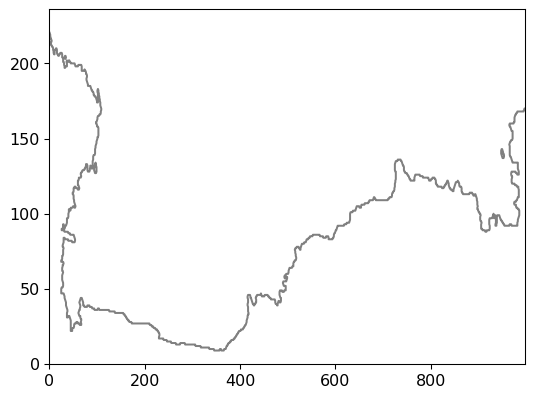

In [8]:
""" Coastal contour"""
coast_land_mask = land_mask.sel(
    yt_ocean=slice(-79, -69), xt_ocean=slice(-200, -100))
xt_ocean = coast_land_mask.xt_ocean
yt_ocean = coast_land_mask.yt_ocean
x_contour = []
y_contour = []

# Create the contour:
cs = plt.contour(coast_land_mask, levels=[0], colors='grey')

for collection in cs.collections:
    for path in collection.get_paths():
        for ii in range(np.size(path.vertices[:, 0])):
            x_contour.append(int(np.round(path.vertices[ii][0])))
            y_contour.append(int(np.round(path.vertices[ii][1])))

lat_contour = np.zeros((len(x_contour)))
lon_contour = np.zeros((len(x_contour)))

for ii in range(len(x_contour)):
    lon_contour[ii] = coast_land_mask.xt_ocean[x_contour[ii]]
    lat_contour[ii] = coast_land_mask.yt_ocean[y_contour[ii]]

# for this coastal contour delete last indices which enclose islands
lat_contour = lat_contour[:-49]
lon_contour = lon_contour[:-49]
dist_contour = distance_along_line(
    lat_contour, lon_contour, return_cum_dist=True)

## Plots

In [9]:
def Fig3(ekeys, time_idx, v_max_map, time_slice, v_max_hovm):
    fig = plt.figure(figsize=(12, 10))
    gs1 = fig.add_gridspec(4, 2,  width_ratios=[1.5, 2], hspace=0.2)
    gs2 = fig.add_gridspec(4, 2,  width_ratios=[1.5, 2], hspace=0.5)

    """ left column: maps """
    ekey = ekeys[0]
    depth_slice = slice(50, None)
    # load variables
    e = exptdict['ctrl']
    var_ctrl = e['salt_d'].isel(time=time_idx).sel(st_ocean=depth_slice)
    # convert units to absolute salinity
    pressure = p_from_z(-var_ctrl.st_ocean, var_ctrl.yt_ocean)
    var_ctrl = SA_from_SP(
        var_ctrl, pressure, var_ctrl.xt_ocean, var_ctrl.yt_ocean)
    dz_weights = e['dzt'][0, :].drop('time').sel(st_ocean=depth_slice)
    dz_weights = dz_weights/dz_weights.sum('st_ocean')
    var_ctrl = (var_ctrl*dz_weights).sum('st_ocean')
    var_ctrl = var_ctrl.where(var_ctrl != 0)
    var_ctrl_shelf, shelf_mask = shelf_mask_isobath(
        var_ctrl, output_mask=True)
    
    e = exptdict[ekey]
    var_shelf = e['salt_d'].isel(time=time_idx).sel(st_ocean=depth_slice)
    # convert units to absolute salinity
    pressure = p_from_z(-var_shelf.st_ocean, var_shelf.yt_ocean)
    var_shelf = SA_from_SP(
        var_shelf, pressure, var_shelf.xt_ocean, var_shelf.yt_ocean)
    dz_weights = e['dzt'][0, :].drop('time').sel(st_ocean=depth_slice)
    dz_weights = dz_weights/dz_weights.sum('st_ocean')
    var_shelf = (var_shelf*dz_weights).sum('st_ocean')
    var_shelf = var_shelf.where(var_shelf != 0)
    var_shelf, shelf_mask = shelf_mask_isobath(
        var_shelf, output_mask=True)
        
    var_diff = (var_shelf - var_ctrl_shelf)
    proj = ccrs.PlateCarree()

    for i in range(len(time_idx)):
        ax = fig.add_subplot(
            gs1[i, 0],
            projection=ccrs.PlateCarree(central_longitude=185))
        ax.set_extent([160, 265, -79, -70])
        
        ax.contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                    land_mask, colors='silver', levels=[0.5, 2],
                    zorder=2, transform=proj)
        plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask,
                    levels=[0, 1], colors = 'k',  transform=proj)
        gl = ax.gridlines(draw_labels=False)
        gl.xlocator = mticker.FixedLocator(
                [180, -160, -140, -120, -100])
        gl.ylocator = mticker.FixedLocator(
                np.arange(-80, -65, 5))
        ax.set_yticks(np.arange(-80, -65, 5), crs=proj)
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        if i == (len(time_idx)-1):
            ax.set_xticks([180, -140, -100], crs=proj)
            ax.xaxis.set_major_formatter(LongitudeFormatter(
                dateline_direction_label=True))
        plt.ylim(-79, None)
        ax.set_aspect('auto')

        if i == 0:
            # contour of coastline
            plt.plot(lon_contour[:2165], lat_contour[:2165], '.', color='k',
                     markersize=.5, transform=proj)
            for d in np.arange(0, 7000, 1000):
                idx = find_nearest(dist_contour, d)
                plt.plot(lon_contour[idx], lat_contour[idx], 'ok', markersize=6,
                         transform=proj)
                if d == 6000:
                    plt.text(
                        lon_contour[idx]-.2, lat_contour[idx]-.05,
                        str(int(np.round(dist_contour[idx], -2))), va='top',
                        fontsize=10, ha='right', transform=proj)
                else:
                    plt.text(
                        lon_contour[idx]-.2, lat_contour[idx]-.27,
                        str(int(np.round(dist_contour[idx], -2))), va='top',
                        fontsize=10, transform=proj)
        
        if ekey == 'wind_50_down_zonal':
            buffer = -1.2
            ax.plot(
                [e['mask_wind'][0][0]-buffer, e['mask_wind'][0][1]-buffer,
                 e['mask_wind'][0][2], e['mask_wind'][0][3]+buffer,
                 e['mask_wind'][0][4]+buffer, e['mask_wind'][0][5],
                 e['mask_wind'][0][6]-buffer],
                [e['mask_wind'][1][0]-buffer, e['mask_wind'][1][1]+buffer,
                 e['mask_wind'][1][2]+buffer, e['mask_wind'][1][3]+buffer,
                 e['mask_wind'][1][4]-buffer, e['mask_wind'][1][5]-buffer,
                 e['mask_wind'][1][6]-buffer],
                color=e['col'], transform=proj)
        else:
            ax.plot([e['pert_lon'][0], e['pert_lon'][0]], [-79, -69],
                    color=e['col'], transform=proj)
            ax.plot([e['pert_lon'][1], e['pert_lon'][1]], [-79, -69],
                    color=e['col'], transform=proj)
            
        p = ax.pcolormesh(
            var_diff.xt_ocean, var_diff.yt_ocean, var_diff[i, :],
            vmin=-v_max_map, vmax=v_max_map, cmap=cmo.balance, transform=proj)
        plt.title(
            string.ascii_lowercase[i] + ') ' + e['expt_str'] + '  -  ' +
            exptdict['ctrl']['expt_str'] + ': ' +
            str(var_diff[i, :].time.dt.day.values) + '. ' +
            calendar.month_name[var_diff[i, :].time.dt.month.values],
            fontweight='bold', loc='left')
        
    pos = ax.get_position()
    cax = plt.axes([pos.xmin, pos.ymin-.08,
                    .8*(pos.xmax-pos.xmin), 0.025])
    cb = plt.colorbar(p, cax=cax, orientation='horizontal', extend='both')
    cb.ax.set_ylabel('g kg$^{-1}$', loc='bottom', labelpad=-210, rotation=0)


    """ right column: Hovmöllers """
    
    e = exptdict['ctrl']
    var_ctrl_line = e['salt_d'].sel(time=time_slice).sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'),
        method='nearest').compute()
    # convert units to absolute salinity
    pressure = p_from_z(-var_ctrl_line.st_ocean, var_ctrl_line.yt_ocean)
    var_ctrl_line = SA_from_SP(var_ctrl_line, pressure,
                               var_ctrl_line.xt_ocean, var_ctrl_line.yt_ocean)

    dz_weights = e['dzt'][0, :].drop('time').sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
    dz_weights = dz_weights/dz_weights.sum('st_ocean')
    var_ctrl_line = (var_ctrl_line*dz_weights).sum('st_ocean')
    var_ctrl_line = var_ctrl_line.where(var_ctrl_line != 0)

    dist_line = distance_along_line(
        lat_contour, lon_contour, return_cum_dist=True)
    var_ctrl_line = var_ctrl_line.isel(distance=slice(0, -1)) # cut off last point
    var_ctrl_line['distance'] = dist_line
    var_ctrl_line = var_ctrl_line.compute()

    for i, ekey in enumerate(ekeys):
        if i == 0:
            ax = fig.add_subplot(gs2[:2, 1])
        else:
            ax = fig.add_subplot(gs2[2:, 1])
    
        e = exptdict[ekey]
        var_line = exptdict[ekey]['salt_d'].sel(time=time_slice).sel(
            yt_ocean=xr.DataArray(lat_contour, dims='distance'),
            xt_ocean=xr.DataArray(lon_contour, dims='distance'),
            method='nearest').compute()
        # convert units to absolute salinity
        pressure = p_from_z(-var_line.st_ocean, var_line.yt_ocean)
        var_line = SA_from_SP(
            var_line, pressure, var_line.xt_ocean, var_line.yt_ocean)
        dz_weights = e['dzt'][0, :].drop('time').sel(
            yt_ocean=xr.DataArray(lat_contour, dims='distance'),
            xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
        dz_weights = dz_weights/dz_weights.sum('st_ocean')
        var_line = (var_line*dz_weights).sum('st_ocean')
        var_line = var_line.where(var_line != 0)
        var_line = var_line.isel(distance=slice(0, -1)) # cut off last point
        var_line['distance'] = dist_line
    
        var = (var_line - var_ctrl_line)
    
        time_axis = np.linspace(0, len(var.time)/365, len(var.time))
        pc = ax.pcolormesh(var.distance, time_axis, var,
                           cmap=cmo.balance, vmin=-v_max_hovm, vmax=v_max_hovm)
    
        if ekey == 'wind_50_down_zonal':
            idx = [435, 1235]
        elif (ekey == 'mw_50_down') or (ekey == 'mw_50_down_over_1_yr'):
            idx = [950, ]
        for ii in idx:
            plt.axvline(var.distance[ii], linewidth=2.5, color=e['col'])
        ax.invert_xaxis()
        ax.set_xlabel('Distance (km)', labelpad=2)
        ax.set_ylabel('Model year')
        
        if ekey == 'wind_50_down_zonal':
            dist_e = 2200
            dist_w = 4800
            time_e = 3/365
            time_w = 70/365
        elif ekey == 'mw_50_down':
            dist_e = 2000
            dist_w = 5000
            time_e = 8/365
            time_w = 85/365
        dt = (time_w - time_e) * 365*24*3600 # in s
        ax.plot([dist_e, dist_w], [time_e, time_w], 'grey', linewidth=2.5)
        ax.text(dist_w-10, time_w+15/365,
                 str(np.round(((dist_w-dist_e)*1000/dt), 2)) +
                 r' m s$^{-1}$', color='k').set_bbox(
            dict(facecolor='white', alpha=0.5, linewidth=0, pad=-.8))
                
        ax.set_title(string.ascii_lowercase[i+len(time_idx)] + ') ' +
                     e['expt_str'] + '  -  ' + exptdict['ctrl']['expt_str'],
                     fontweight='bold', loc='left')
    
    pos = ax.get_position()
    cax = plt.axes([pos.xmin, pos.ymin-.08,
                    .8*(pos.xmax-pos.xmin), 0.025])
    cb = plt.colorbar(pc, cax=cax, orientation='horizontal', extend='both')
    cb.ax.set_ylabel('g kg$^{-1}$', loc='bottom', labelpad=-280, rotation=0)
    
    # plt.savefig(path_plots + 'Fig3.png', dpi=300, bbox_inches="tight")
    plt.show()

In [14]:
def Fig4(ekey, v_max_ssh, time_slice, depth_max_spd, v_max_spd,
         lon, lat, depth_max_rho, c_levels_rho, v_max_rho):

    plt.figure(figsize=(6, 11))
    plt.subplots_adjust(hspace=.18, wspace=.1)

    e = exptdict[ekey]

    """ a) Hovmöller of daily ssh """
    ssh = e['ssh_d']
    ssh_line = ssh.sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
    dist_line = distance_along_line(
        lat_contour, lon_contour, return_cum_dist=True)
    ssh_line = ssh_line.isel(distance=slice(0, -1)) # cut of last point
    ssh_line['distance'] = dist_line

    ssh = exptdict['ctrl']['ssh_d']
    ssh_ctrl_line = ssh.sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
    ssh_ctrl_line = ssh_ctrl_line.isel(distance=slice(0, -1)) # cut of last point
    ssh_ctrl_line['distance'] = dist_line

    ssh = ((ssh_line - ssh_ctrl_line)*100)

    plt.subplot(3, 1, 1)
    time_axis = np.arange(len(ssh.time))
    p = plt.pcolormesh(ssh.distance, time_axis, ssh,
                       cmap=cmo.balance, vmin=-v_max_ssh, vmax=v_max_ssh)

    if ekey == 'wind_50_down_zonal':
        idx = [435, 1235]
    elif (ekey == 'mw_50_down') or (ekey == 'mw_50_down_over_1_yr'):
        idx = [950, ]
    for ii in idx:
        plt.axvline(ssh.distance[ii], color=e['col'])
    plt.xlim(5500, 0)
    plt.xlabel('Distance (km)', labelpad=0)
    plt.ylabel('Days', labelpad=6)
    plt.text(.01, .93, string.ascii_lowercase[0] + ') ',
                   fontweight='bold', transform=plt.gca().transAxes)

    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax+.02, pos.ymin,
                0.03, .92*(pos.ymax-pos.ymin)])
    cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='min',
                      ticks=[-5, 0, 5])
    cb.ax.set_title('cm')

    """ b) map of upper ocean velocity """
    plt.subplot(3, 1, 2, projection=ccrs.PlateCarree(central_longitude=185))
    proj = ccrs.PlateCarree()

    # load variables
    e = exptdict['ctrl']
    u_ctrl = e['u'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
    v_ctrl = e['v'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
    # need to rename xt_ocean/yt_ocean as I didn't save dzu
    dz_weights = e['dzt'].sel(time=time_slice, st_ocean=slice(depth_max_spd)).drop(
        ['xt_ocean', 'yt_ocean']).rename(
        {'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
    dz_weights = (dz_weights/dz_weights.sum('st_ocean')).squeeze()
    u_ctrl = yearly_mean((u_ctrl*dz_weights).sum('st_ocean')).squeeze()
    u_ctrl = u_ctrl.where(u_ctrl != 0)
    v_ctrl = yearly_mean((v_ctrl*dz_weights).sum('st_ocean')).squeeze()
    v_ctrl = v_ctrl.where(v_ctrl != 0)
    spd_ctrl = np.sqrt(u_ctrl**2 + v_ctrl**2)
    var_shelf, shelf_mask = shelf_mask_isobath(e['dzt'], output_mask=True)

    e = exptdict[ekey]
    u = e['u'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
    v = e['v'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
    # need to rename xt_ocean/yt_ocean as I didn't save dzu
    dz_weights = e['dzt'].sel(time=time_slice, st_ocean=slice(depth_max_spd)).drop(
        ['xt_ocean', 'yt_ocean']).rename(
        {'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
    dz_weights = (dz_weights/dz_weights.sum('st_ocean')).squeeze()
    u = yearly_mean((u*dz_weights).sum('st_ocean')).squeeze()
    u = u.where(u != 0)
    v = yearly_mean((v*dz_weights).sum('st_ocean')).squeeze()
    v = v.where(v != 0)
    spd = np.sqrt(u**2 + v**2)
    
    u_diff = (u - u_ctrl)*100 # in cm/s
    v_diff = (v - v_ctrl)*100 # in cm/s
    spd_diff = (spd - spd_ctrl)*100 # in cm/s
    coars_x = 20
    coars_y = 8
    u_diff_coars = u_diff.coarsen(xu_ocean=coars_x, boundary='trim').mean(
        ).coarsen(yu_ocean=coars_y, boundary='trim').mean()
    v_diff_coars = v_diff.coarsen(xu_ocean=coars_x, boundary='trim').mean(
        ).coarsen(yu_ocean=coars_y, boundary='trim').mean()

    ax = plt.gca()
    ax.set_extent([160, 255, -79, -72])
    ax.contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                land_mask, colors='silver', levels=[0.5, 2],
                zorder=2, transform=proj)
    gl = ax.gridlines(draw_labels=False)
    gl.xlocator = mticker.FixedLocator(
        [180, -160, -140, -120])
    ax.set_xticks([180, -160, -140, -120], crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter(
        dateline_direction_label=True))
    gl.ylocator = mticker.FixedLocator([-78, -75, -72])
    ax.set_yticks([-78, -75, -72], crs=proj)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim(-79, None)
    ax.set_aspect('auto')

    # contour of coastline
    ax.plot(lon_contour[:1890], lat_contour[:1890], '.', color='k',
            markersize=1, transform=proj)
    for d in np.arange(1000, 6000, 1000):
        idx = find_nearest(dist_contour, d)
        ax.plot(lon_contour[idx], lat_contour[idx], 'ok',
                markersize=6, transform=proj)
        if (d == 1000) or (d == 4000):
            ax.text(lon_contour[idx]-.2, lat_contour[idx]-.15,
                    str(int(np.round(dist_contour[idx], -2))),
                    va='top', ha='right', transform=proj)
        else:
            ax.text(lon_contour[idx], lat_contour[idx]-.15,
                    str(int(np.round(dist_contour[idx], -2))),
                    va='top', transform=proj)
    for l in range(len(lon)):
        ax.plot([lon[l], lon[l]], [lat[l].start, lat[l].stop], color='magenta',
                transform=proj)
    
    if ekey == 'wind_50_down_zonal':
        buffer = -1.2
        ax.plot([e['mask_wind'][0][0]-buffer, e['mask_wind'][0][1]-buffer,
                 e['mask_wind'][0][2], e['mask_wind'][0][3]+buffer,
                 e['mask_wind'][0][4]+buffer, e['mask_wind'][0][5],
                 e['mask_wind'][0][6]-buffer],
                [e['mask_wind'][1][0]-buffer, e['mask_wind'][1][1]+buffer,
                 e['mask_wind'][1][2]+buffer, e['mask_wind'][1][3]+buffer,
                 e['mask_wind'][1][4]-buffer, e['mask_wind'][1][5]-buffer,
                 e['mask_wind'][1][6]-buffer],
                color=e['col'], transform=proj)
    else:
        ax.plot([e['pert_lon'][0], e['pert_lon'][0]], [-79, -69],
                color=e['col'], transform=proj)
        ax.plot([e['pert_lon'][1], e['pert_lon'][1]], [-79, -69],
                color=e['col'], transform=proj)

    p = ax.pcolormesh(
        spd_diff.xu_ocean, spd_diff.yu_ocean, spd_diff,
        vmin=-v_max_spd, vmax=v_max_spd, cmap=cmo.balance, transform=proj)
    ax.text(.01, .93, string.ascii_lowercase[1] + ') ',
            fontweight='bold', transform=plt.gca().transAxes)

    qr = ax.quiver(u_diff_coars.xu_ocean, u_diff_coars.yu_ocean,
                   u_diff_coars.values, v_diff_coars.values,
                   scale=150, width=0.003, transform=proj)

    pos = ax.get_position()
    cax = plt.axes([pos.xmax+.02, pos.ymin,
                    0.03, .93*(pos.ymax-pos.ymin)])
    cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='both')
    cb.ax.set_title(r'cm s$^{-1}$', x=1.2)

    """ c) sections of rho """
    cmap_mod =  cmocean.tools.crop_by_percent(
        cmo.balance, 15, which='both', N=None)
    
    for l in range(len(lon)):
        e = exptdict['ctrl']
        rho0 = yearly_mean(e['rho0'].sel(time=time_slice)).squeeze()
        var_section = rho0.sel(xt_ocean=lon[l], method='nearest').sel(
           yt_ocean=lat[l], st_ocean=slice(0, depth_max_rho))
        var_section_ctrl = var_section.where(var_section != 0).compute()

        e = exptdict[ekey]
        rho0 = yearly_mean(e['rho0'].sel(time=time_slice)).squeeze()
        var_section = rho0.sel(xt_ocean=lon[l], method='nearest').sel(
           yt_ocean=lat[l], st_ocean=slice(0, depth_max_rho))
        var_section = var_section.where(var_section != 0).compute()

        plt.subplot(3, 2, l+5)
        cs = plt.contour(var_section.yt_ocean, var_section.st_ocean,
                         var_section_ctrl, levels=c_levels_rho[l], colors='k')
        plt.clabel(cs, inline=True, use_clabeltext=True, colors='k',
                   fmt='%1.2f', fontsize=10)
        plt.contour(var_section.yt_ocean, var_section.st_ocean,
                    var_section, levels=c_levels_rho[l], colors=e['col'])
        var_section = var_section - var_section_ctrl
        pp = plt.pcolormesh(
            var_section.yt_ocean, var_section.st_ocean, var_section,
            cmap=cmap_mod, vmin=-v_max_rho, vmax=v_max_rho)
        plt.xlabel('Latitude')
        if l == 0:
            plt.ylabel('Depth (m)', labelpad=1)
        else:
            plt.gca().set_yticklabels([])
        plt.text(.02, .93, string.ascii_lowercase[l+2] + ') ',
                 fontweight='bold', transform=plt.gca().transAxes)
        if lon[l] < -180:
            lon_str = str(lon[l]+360) + '°E'
        elif lon[l] < 0:
            lon_str = str(np.abs(lon[l])) + '°W'
        plt.text(.02, .02, lon_str, fontweight='bold',
                 transform=plt.gca().transAxes)
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_major_formatter(LatitudeFormatter())
    
    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax+.02, pos.ymin,
                    0.03, .93*(pos.ymax-pos.ymin)])
    cb = plt.colorbar(pp, cax=cax, orientation='vertical', extend='both')
    cb.ax.set_title('kg m$^{-3}$', x=1.3)

    # plt.savefig(path_plots + 'Fig4.png', dpi=300, bbox_inches="tight")
    plt.show()

In [15]:
def FigS6(ekey, v_max_ssh, time_slice_all, depth_max_spd, v_max_spd,
          lon, lat, depth_max_rho, c_levels_rho, v_max_rho):

    plt.figure(figsize=(11, 11))
    plt.subplots_adjust(hspace=.2, wspace=1.8)

    e = exptdict[ekey]

    """ a) Hovmöller of daily ssh """
    ssh = e['ssh_d']
    ssh_line = ssh.sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
    dist_line = distance_along_line(
        lat_contour, lon_contour, return_cum_dist=True)
    ssh_line = ssh_line.isel(distance=slice(0, -1)) # cut of last point
    ssh_line['distance'] = dist_line

    ssh = exptdict['ctrl']['ssh_d']
    ssh_ctrl_line = ssh.sel(
        yt_ocean=xr.DataArray(lat_contour, dims='distance'),
        xt_ocean=xr.DataArray(lon_contour, dims='distance'), method='nearest')
    ssh_ctrl_line = ssh_ctrl_line.isel(distance=slice(0, -1)) # cut of last point
    ssh_ctrl_line['distance'] = dist_line

    ssh = ((ssh_line - ssh_ctrl_line)*100)

    plt.subplot(3, 5, (1, 3))
    time_axis = np.arange(len(ssh.time))
    p = plt.pcolormesh(ssh.distance, time_axis, ssh,
                       cmap=cmo.balance, vmin=-v_max_ssh, vmax=v_max_ssh)

    if ekey == 'wind_50_down_zonal':
        idx = [435, 1235]
    elif (ekey == 'mw_50_down') or (ekey == 'mw_50_down_over_1_yr'):
        idx = [950, ]
    for ii in idx:
        plt.axvline(ssh.distance[ii], color=e['col'])
    plt.xlim(5500, 0)
    plt.xlabel('Distance (km)', labelpad=0)
    plt.ylabel('Days', labelpad=6)
    plt.text(.01, .93, string.ascii_lowercase[0] + ') ',
                   fontweight='bold', transform=plt.gca().transAxes)

    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax+.01, pos.ymin,
                    0.018, .92*(pos.ymax-pos.ymin)])
    cb = plt.colorbar(p, cax=cax, orientation='vertical',
                      extend='min', ticks=[-5, 0, 5])
    cb.ax.set_title('cm')

    for l, time_slice in enumerate(time_slice_all):
        
        """ map of upper ocean velocity """
        plt.subplot(3, 5, (6+5*l, 8+5*l), projection=ccrs.PlateCarree(
            central_longitude=185))
        proj = ccrs.PlateCarree()
    
        # load variables
        e = exptdict['ctrl']
        u_ctrl = e['u'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
        v_ctrl = e['v'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
        # need to rename xt_ocean/yt_ocean as I didn't save dzu
        dz_weights = e['dzt'].sel(time=time_slice, st_ocean=slice(depth_max_spd)).drop(
            ['xt_ocean', 'yt_ocean']).rename(
            {'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
        dz_weights = (dz_weights/dz_weights.sum('st_ocean')).squeeze()
        u_ctrl = yearly_mean((u_ctrl*dz_weights).sum('st_ocean')).squeeze()
        u_ctrl = u_ctrl.where(u_ctrl != 0)
        v_ctrl = yearly_mean((v_ctrl*dz_weights).sum('st_ocean')).squeeze()
        v_ctrl = v_ctrl.where(v_ctrl != 0)
        spd_ctrl = np.sqrt(u_ctrl**2 + v_ctrl**2)
        var_shelf, shelf_mask = shelf_mask_isobath(e['dzt'], output_mask=True)
    
        e = exptdict[ekey]
        u = e['u'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
        v = e['v'].sel(time=time_slice, st_ocean=slice(depth_max_spd))
        # need to rename xt_ocean/yt_ocean as I didn't save dzu
        dz_weights = e['dzt'].sel(time=time_slice, st_ocean=slice(depth_max_spd)).drop(
            ['xt_ocean', 'yt_ocean']).rename(
            {'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
        dz_weights = (dz_weights/dz_weights.sum('st_ocean')).squeeze()
        u = yearly_mean((u*dz_weights).sum('st_ocean')).squeeze()
        u = u.where(u != 0)
        v = yearly_mean((v*dz_weights).sum('st_ocean')).squeeze()
        v = v.where(v != 0)
        spd = np.sqrt(u**2 + v**2)
        
        u_diff = (u - u_ctrl)*100 # in cm/s
        v_diff = (v - v_ctrl)*100 # in cm/s
        spd_diff = (spd - spd_ctrl)*100 # in cm/s
        coars_x = 20
        coars_y = 8
        u_diff_coars = u_diff.coarsen(xu_ocean=coars_x, boundary='trim').mean(
            ).coarsen(yu_ocean=coars_y, boundary='trim').mean()
        v_diff_coars = v_diff.coarsen(xu_ocean=coars_x, boundary='trim').mean(
            ).coarsen(yu_ocean=coars_y, boundary='trim').mean()
    
        ax = plt.gca()
        ax.set_extent([160, 255, -79, -72])
        ax.contourf(land_mask.xt_ocean, land_mask.yt_ocean,
                    land_mask, colors='silver', levels=[0.5, 2],
                    zorder=2, transform=proj)
        gl = ax.gridlines(draw_labels=False)
        gl.xlocator = mticker.FixedLocator(
            [180, -160, -140, -120])
        ax.set_xticks([180, -160, -140, -120], crs=proj)
        ax.xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
        gl.ylocator = mticker.FixedLocator([-78, -75, -72])
        ax.set_yticks([-78, -75, -72], crs=proj)
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.set_ylim(-79, None)
        ax.set_aspect('auto')
    
        # contour of coastline
        ax.plot(lon_contour[:1890], lat_contour[:1890], '.', color='k',
                markersize=1, transform=proj)
        for d in np.arange(1000, 6000, 1000):
            idx = find_nearest(dist_contour, d)
            ax.plot(lon_contour[idx], lat_contour[idx], 'ok',
                    markersize=6, transform=proj)
            if (d == 1000) or (d == 4000):
                ax.text(lon_contour[idx]-.2, lat_contour[idx]-.15,
                        str(int(np.round(dist_contour[idx], -2))),
                        va='top', ha='right', transform=proj)
            else:
                ax.text(lon_contour[idx], lat_contour[idx]-.15,
                        str(int(np.round(dist_contour[idx], -2))),
                        va='top', transform=proj)
        ax.plot([lon, lon], [lat.start, lat.stop], color='magenta',
                transform=proj)
        
        if ekey == 'wind_50_down_zonal':
            buffer = -1.2
            ax.plot([e['mask_wind'][0][0]-buffer, e['mask_wind'][0][1]-buffer,
                     e['mask_wind'][0][2], e['mask_wind'][0][3]+buffer,
                     e['mask_wind'][0][4]+buffer, e['mask_wind'][0][5],
                     e['mask_wind'][0][6]-buffer],
                    [e['mask_wind'][1][0]-buffer, e['mask_wind'][1][1]+buffer,
                     e['mask_wind'][1][2]+buffer, e['mask_wind'][1][3]+buffer,
                     e['mask_wind'][1][4]-buffer, e['mask_wind'][1][5]-buffer,
                     e['mask_wind'][1][6]-buffer],
                    color=e['col'], transform=proj)
        else:
            ax.plot([e['pert_lon'][0], e['pert_lon'][0]], [-79, -69],
                    color=e['col'], transform=proj)
            ax.plot([e['pert_lon'][1], e['pert_lon'][1]], [-79, -69],
                    color=e['col'], transform=proj)
    
        p = ax.pcolormesh(
            spd_diff.xu_ocean, spd_diff.yu_ocean, spd_diff,
            vmin=-v_max_spd, vmax=v_max_spd, cmap=cmo.balance, transform=proj)
        ax.text(.01, .93, string.ascii_lowercase[l*2+1] + ') ',
                fontweight='bold', transform=plt.gca().transAxes)
    
        qr = ax.quiver(u_diff_coars.xu_ocean, u_diff_coars.yu_ocean,
                       u_diff_coars.values, v_diff_coars.values,
                       scale=150, width=0.003, transform=proj)
    
        pos = ax.get_position()
        cax = plt.axes([pos.xmax+.01, pos.ymin,
                        0.018, .93*(pos.ymax-pos.ymin)])
        cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='both')
        cb.ax.set_title(r'cm s$^{-1}$', x=1.2)

        """ sections of rho """
        cmap_mod =  cmocean.tools.crop_by_percent(
            cmo.balance, 15, which='both', N=None)

        e = exptdict['ctrl']
        rho0 = yearly_mean(e['rho0'].sel(time=time_slice)).squeeze()
        var_section = rho0.sel(xt_ocean=lon, method='nearest').sel(
           yt_ocean=lat, st_ocean=slice(0, depth_max_rho))
        var_section_ctrl = var_section.where(var_section != 0).compute()

        e = exptdict[ekey]
        rho0 = yearly_mean(e['rho0'].sel(time=time_slice)).squeeze()
        var_section = rho0.sel(xt_ocean=lon, method='nearest').sel(
           yt_ocean=lat, st_ocean=slice(0, depth_max_rho))
        var_section = var_section.where(var_section != 0).compute()

        plt.subplot(3, 5, (9+5*l, 10+5*l))
        cs = plt.contour(var_section.yt_ocean, var_section.st_ocean,
                         var_section_ctrl, levels=c_levels_rho, colors='k')
        plt.clabel(cs, inline=True, use_clabeltext=True, colors='k',
                   fmt='%1.2f', fontsize=10)
        plt.contour(var_section.yt_ocean, var_section.st_ocean,
                    var_section, levels=c_levels_rho, colors=e['col'])
        var_section = var_section - var_section_ctrl
        pp = plt.pcolormesh(
            var_section.yt_ocean, var_section.st_ocean, var_section,
            cmap=cmap_mod, vmin=-v_max_rho, vmax=v_max_rho)
        plt.xlabel('Latitude', labelpad=2)
        plt.ylabel('Depth (m)', labelpad=1)
        plt.text(.02, .93, string.ascii_lowercase[l*2+2] + ') ',
                 fontweight='bold', transform=plt.gca().transAxes)
        if lon < -180:
            lon_str = str(lon+360) + '°E'
        elif lon < 0:
            lon_str = str(np.abs(lon)) + '°W'
        plt.text(.02, .02, lon_str, fontweight='bold', transform=plt.gca().transAxes)
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_major_formatter(LatitudeFormatter())
        
        pos = plt.gca().get_position()
        cax = plt.axes([pos.xmax+.01, pos.ymin,
                        0.018, .93*(pos.ymax-pos.ymin)])
        cb = plt.colorbar(pp, cax=cax, orientation='vertical', extend='both')
        cb.ax.set_title('kg m$^{-3}$', x=1.3)

    # plt.savefig(path_plots + 'FigS6.png', dpi=300, bbox_inches="tight")
    plt.show()

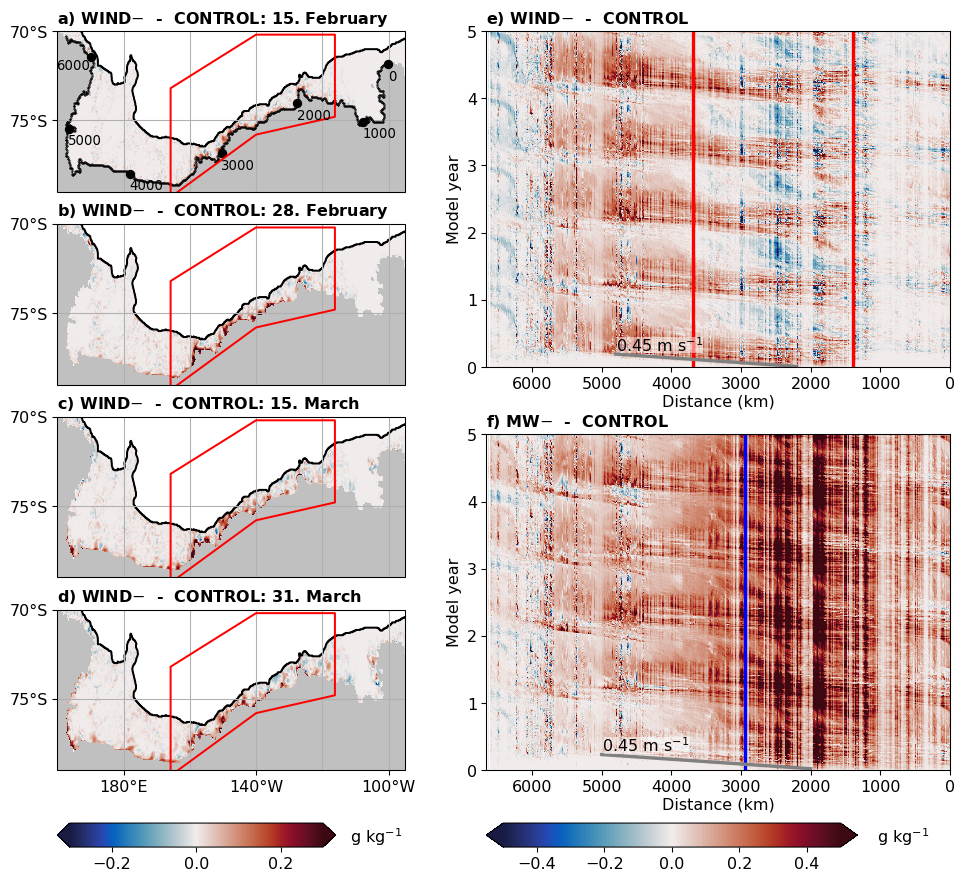

CPU times: user 3min 28s, sys: 40.9 s, total: 4min 9s
Wall time: 8min 58s


In [12]:
ekeys = ['wind_50_down_zonal', 'mw_50_down']
time_idx = [45, 58, 73, 89]
v_max_map = .3
time_slice = slice('2150', '2154')
v_max_hovm = .5

Fig3(ekeys, time_idx, v_max_map, time_slice, v_max_hovm)

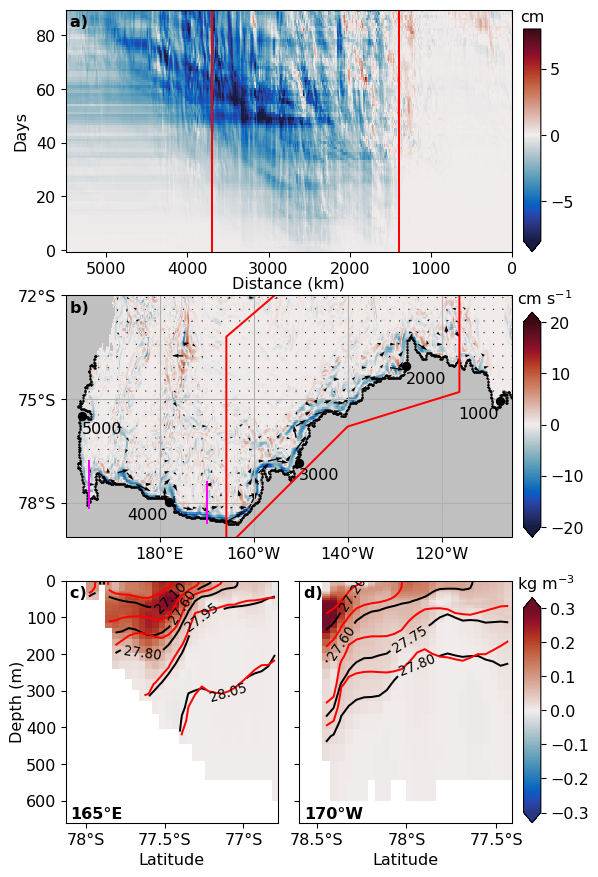

In [16]:
ekey = 'wind_50_down_zonal'
v_max_ssh = 8
time_slice = slice("2150-03", "2150-03")
depth_max_spd = 200
v_max_spd = 20  # 7
lon = [-195, -170]  # 165E, 170W
lat = [slice(-78.15, -76.8), slice(-78.6, -77.4)]
depth_max_rho = 640
c_levels_rho = [[27.1, 27.6, 27.8, 27.95, 28.05],
                [27.2, 27.6, 27.75, 27.8]]
v_max_rho = .3

Fig4(ekey, v_max_ssh, time_slice, depth_max_spd, v_max_spd,
     lon, lat, depth_max_rho, c_levels_rho, v_max_rho)

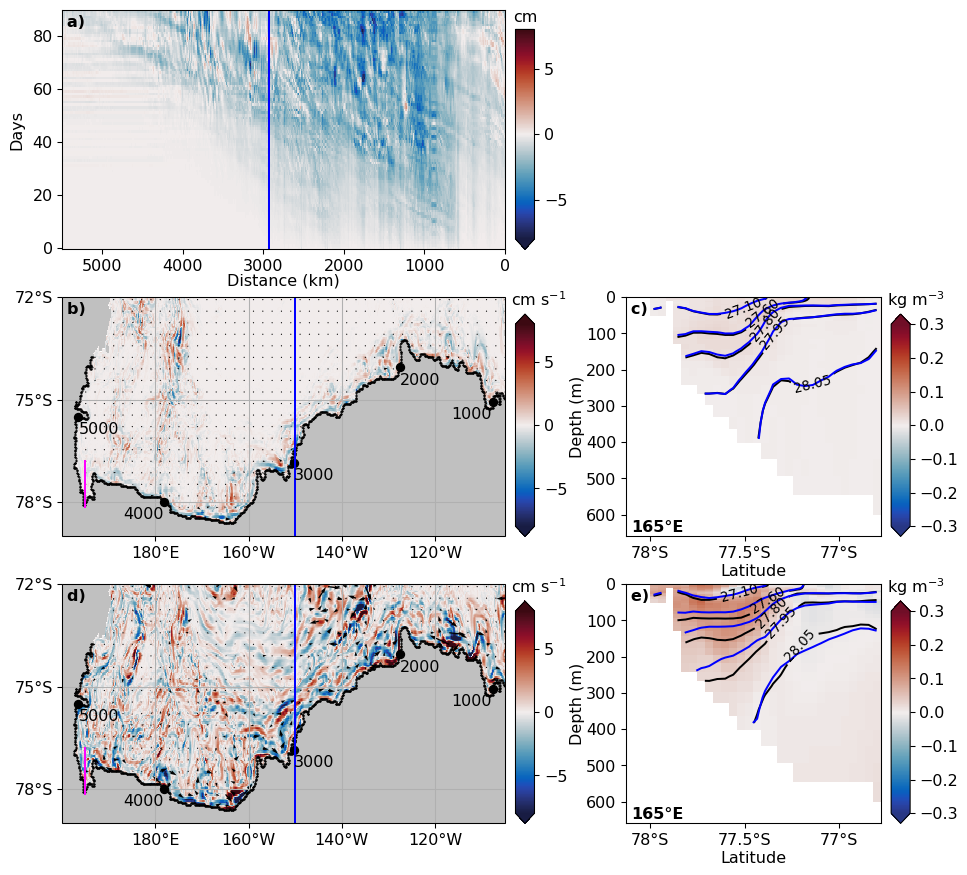

In [17]:
ekey = 'mw_50_down'
v_max_ssh = 8
time_slice = [slice("2150-02", "2150-03"), slice("2151-02", "2151-03")]
depth_max_spd = 200
v_max_spd = 8
lon = -195  # 165E
lat = slice(-78.15, -76.8)
depth_max_rho = 640
c_levels_rho = [27.1, 27.6, 27.8, 27.95, 28.05]
v_max_rho = .3

FigS6(ekey, v_max_ssh, time_slice, depth_max_spd, v_max_spd,
     lon, lat, depth_max_rho, c_levels_rho, v_max_rho)